# Optimized Overlapping Genes Simulation

This notebook runs the overlapping genes simulation using the **optimized** `overlappingGenes.py` module (Numba JIT compiled).
It also includes a comprehensive benchmarking suite comparing it against the original unoptimized code (`overlappingGenesoriginal.py`).

In [1]:
import numpy as np
import time
import os
import multiprocessing as mp
from pathlib import Path
import pickle
import pandas as pd

import matplotlib.pyplot as plt

# Try importing seaborn for nicer plots, but fallback if missing
try:
    import seaborn as sns
    sns.set_context("talk",rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
    sns.set_style("whitegrid",{"grid.color": '.9', 'grid.linestyle': '--','axes.edgecolor': '.6', 'xtick.bottom': True,'ytick.left': True})
    HAS_SEABORN = True
except ImportError:
    print("Seaborn not found. Using standard matplotlib styles.")
    plt.style.use('ggplot')
    HAS_SEABORN = False

import palettable as pal

colorTable = {}
colorTable['k'] = [0,0,0]
colorTable['g'] = [27/255,158/255,119/255]
colorTable['o'] = [217/255,95/255,2/255]

# Import from the OPTIMIZED module
from overlappingGenes import extract_params, initial_seq_no_stops, overlapped_sequence_generator_int, load_natural_energies

#### Functions

def load_data(family1,family2,verbose=False):
    """
    Load the data for a given pair of families.
    """
    dcaparams1 = root + family1 + '/' + family1 + '_params.dat'
    dcaparams2 = root + family2 + '/' + family2 + '_params.dat'

    Js_1, hs_1 = extract_params(dcaparams1)
    Js_2, hs_2 = extract_params(dcaparams2)

    # Length in amino acids, not including stop codons
    lenprot1 = len(hs_1)/21  # 21 is the number of amino acids incl blank
    lenprot2 = len(hs_2)/21  # 21 is the number of amino acids incl blank
   
    # Combining parameters
    DCA_params_1 = [Js_1, hs_1]
    DCA_params_2 = [Js_2, hs_2]

    return DCA_params_1, DCA_params_2, lenprot1, lenprot2

def process_single_overlap(params):
    """Process a single overlap combination and save results"""
    family1, family2, t1, t2, overlapLen = params
    
    # Create unique identifier for this run
    run_id = f"{family1}_{family2}_overlap{overlapLen}"
    
    # Load data
    DCA_params_1, DCA_params_2, lenprot1, lenprot2 = load_data(family1, family2)
        

    results = {}
    for rep in range(numreps):
        # Generate initial sequence
        initialCondition = initial_seq_no_stops(lenprot1, lenprot2, overlapLen,quiet=True)

        # Run simulation. Output is [seq, acceptedornot, energy_history_seq_1, energy_history_seq_2, finalenergies]
        # Note: The optimized function signature is the same, but runs much faster.
        output = overlapped_sequence_generator_int(DCA_params_1, DCA_params_2,
                                                initialCondition, 
                                                numberofiterations=numiter,
                                                T1=t1, T2=t2, quiet=True, whentosave=howoften)
        
        # Store only final results
        results[rep] = {
            'run_id': run_id,
            'initial_sequence': initialCondition,
            'final_sequence': output[0],
            'energy1': output[2],  # Energy time series for sequence 1
            'energy2': output[3],  # Energy time series for sequence 2
            'final_energies': output[4],  # Final energies for both sequences
            'parameters': {
                'family1': family1, 
                'family2': family2,
                'overlap': overlapLen,
                'T1': t1,
                'T2': t2,
                'num_iterations': numiter
            }
        }
    
    print(f"Completed {run_id}")

    return results

Seaborn not found. Using standard matplotlib styles.


ModuleNotFoundError: No module named 'palettable'

In [2]:
#### Parameters

root = "./"

families = ['PF00004', 'PF00041']
family_temperatures = [0.8,0.93] # Temperatures for the two families, picked by Kabir to match natural sequence statistics

numiter = 50000   # Number of iterations for the sequence generator
numreps = 5       # How many independent replicates
howoften = 0.005  # How often to save the energy during generation. Multiply by 100 to get percentage of iterations

#### Overlap away

family1, family2 = families[0],families[1]
t1, t2 = family_temperatures[0], family_temperatures[1]

DCA_params_1, DCA_params_2, lenprot1, lenprot2 = load_data(family1, family2)
print(f"Prot1 Len: {lenprot1} AA, Prot2 Len: {lenprot2} AA")

overlapLength = 20
print(f"Running simulation with overlap {overlapLength}...")
start_time = time.time()
overlappingResults = process_single_overlap([family1, family2, t1, t2, overlapLength])
end_time = time.time()
print(f"Simulation finished in {end_time - start_time:.2f} seconds")

Prot1 Len: 110.0 AA, Prot2 Len: 74.0 AA
Running simulation with overlap 20...
Completed PF00004_PF00041_overlap20
Simulation finished in 5.12 seconds


In [3]:
# Read in the energies of natural sequences
naturalenergies1_file = "./PF00004/PF00004_naturalenergies.txt"
naturalenergies2_file = "./PF00041/PF00041_naturalenergies.txt"

naturalenergies1 = load_natural_energies(naturalenergies1_file)
naturalenergies2 = load_natural_energies(naturalenergies2_file)
mean_1 = np.mean(naturalenergies1)
mean_2 = np.mean(naturalenergies2)
sd_1 = np.std(naturalenergies1)
sd_2 = np.std(naturalenergies2)

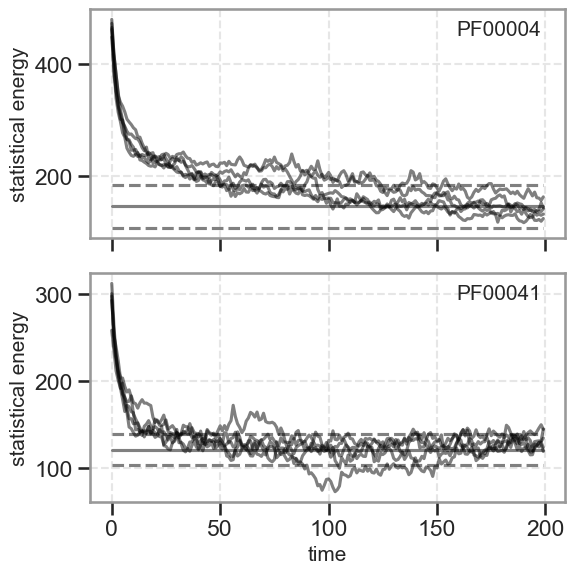

In [4]:
#### Plot results

fig, axs = plt.subplots(2,1, sharex = True)
fig.set_size_inches(6,6)

xv = np.arange(len(overlappingResults[0]["energy1"]))
energy1 = overlappingResults[0]["energy1"] 
energy2 = overlappingResults[0]["energy2"]

xv = np.arange(len(overlappingResults[0]["energy1"]))
axs[0].plot(xv, np.ones_like(energy1)*mean_1, "-", color = "gray")
axs[0].plot(xv, np.ones_like(energy1)*(mean_1 + sd_1), "--", color = "gray")
axs[0].plot(xv, np.ones_like(energy1)*(mean_1 - sd_1), "--", color = "gray")
axs[1].plot(xv, np.ones_like(energy1)*mean_2, "-", color = "gray")
axs[1].plot(xv, np.ones_like(energy1)*(mean_2 + sd_2), "--", color = "gray")
axs[1].plot(xv, np.ones_like(energy1)*(mean_2 - sd_2), "--", color = "gray")

for rep in range(numreps):
    energy1 = overlappingResults[rep]["energy1"]
    energy2 = overlappingResults[rep]["energy2"]
    axs[0].plot(energy1, "k", alpha = 0.5)
    axs[1].plot(energy2, "k", alpha = 0.5)

axs[0].text(0.95, 0.95, f'{family1}', horizontalalignment='right',verticalalignment='top', transform=axs[0].transAxes)
axs[1].text(0.95, 0.95, f'{family2}', horizontalalignment='right',verticalalignment='top', transform=axs[1].transAxes)

axs[-1].set_xlabel("time")
axs[0].set_ylabel("statistical energy")
axs[1].set_ylabel("statistical energy")

plt.tight_layout()

# Robust Benchmarking Suite

This section performs a detailed comparison between the optimized and original implementations.
We will evaluate:
1. **Scaling**: How execution time scales with the number of iterations.
2. **Stability**: Execution time per block of iterations to check for memory leaks or GC issues.
3. **Statistical Validation**: Comparing energy distributions to ensure correctness.
4. **Throughput**: Raw iterations per second.

In [5]:
import overlappingGenes as og_opt
import overlappingGenesoriginal as og_slow

# Setup common parameters for benchmarking
bench_overlap = 20
bench_initial_seq = og_opt.initial_seq_no_stops(lenprot1, lenprot2, bench_overlap, quiet=True)

print("Benchmarking setup complete.")

Benchmarking setup complete.


## 1. Scaling Analysis (Time vs Iterations)

Running Scaling Analysis...
  Testing N=1000...
  Testing N=5000...
  Testing N=10000...
  Testing N=50000...
  Testing N=100000...
  Testing N=500000...


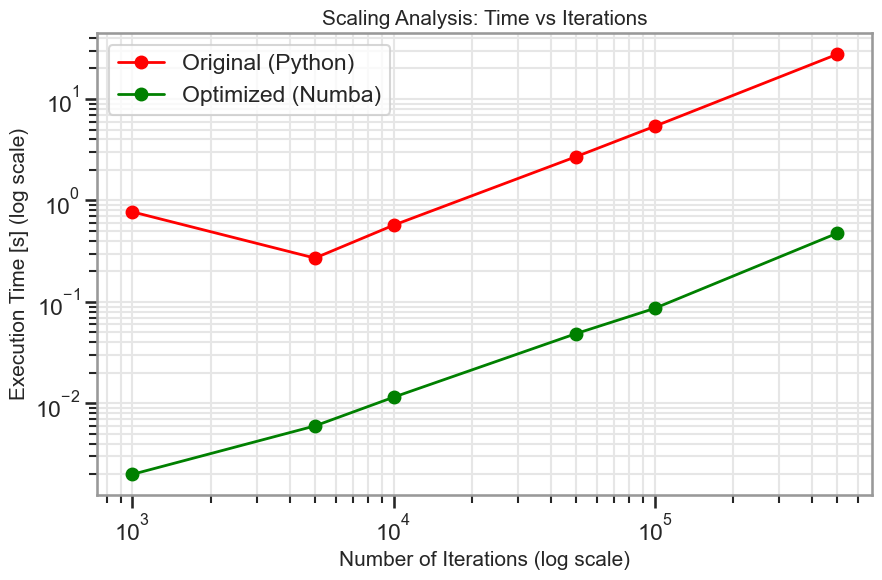

In [6]:
iteration_counts = [1000, 5000, 10000, 50000, 100000, 500000]
times_slow = []
times_fast = []

print("Running Scaling Analysis...")
for n_iter in iteration_counts:
    print(f"  Testing N={n_iter}...")
    
    # Original
    t0 = time.time()
    og_slow.overlapped_sequence_generator_int(
        DCA_params_1, DCA_params_2, bench_initial_seq, 
        T1=t1, T2=t2, numberofiterations=n_iter, quiet=True, whentosave=1.0
    )
    times_slow.append(time.time() - t0)
    
    # Optimized
    t0 = time.time()
    og_opt.overlapped_sequence_generator_int(
        DCA_params_1, DCA_params_2, bench_initial_seq, 
        T1=t1, T2=t2, numberofiterations=n_iter, quiet=True, whentosave=1.0
    )
    times_fast.append(time.time() - t0)

# Plotting
plt.figure(figsize=(10, 6))
plt.loglog(iteration_counts, times_slow, 'o-', label='Original (Python)', color='red', linewidth=2)
plt.loglog(iteration_counts, times_fast, 'o-', label='Optimized (Numba)', color='green', linewidth=2)
plt.xlabel('Number of Iterations (log scale)')
plt.ylabel('Execution Time [s] (log scale)')
plt.title('Scaling Analysis: Time vs Iterations')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()

## 2. Stability Analysis (Time per Block)
We run a longer simulation and measure the time taken for every 1,000 iterations. This helps identify performance degradation over time (e.g., due to memory leaks).

Running Stability Analysis...


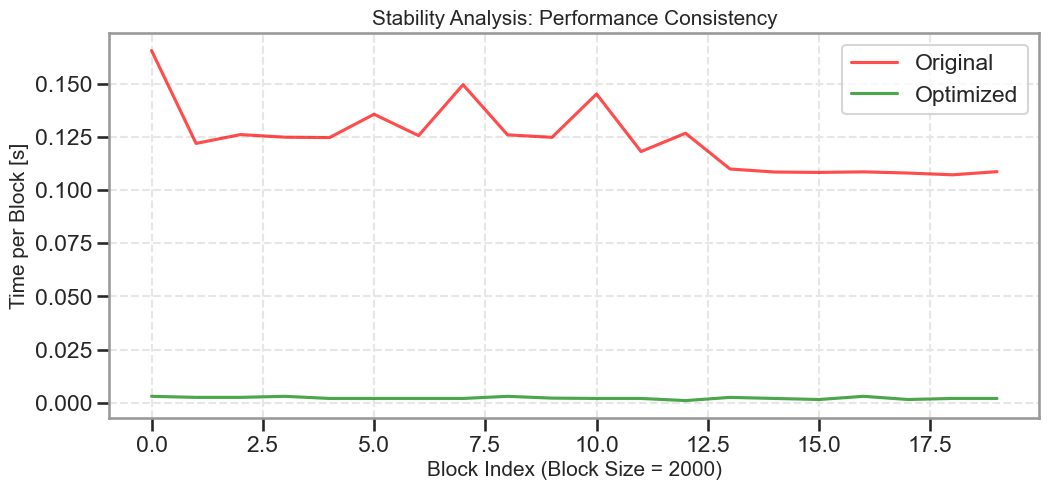

In [7]:
# We can't easily instrument the internal loop of the *original* code without modifying it.
# Instead, we will run multiple short chunks sequentially to simulate this.

block_size = 2000
num_blocks = 20
blocks = np.arange(num_blocks)

block_times_slow = []
block_times_fast = []

print("Running Stability Analysis...")

# Original Stability
curr_seq = bench_initial_seq
for i in range(num_blocks):
    t0 = time.time()
    # We run for block_size iterations
    # Note: We pass the output sequence of the previous block as input to the next
    out = og_slow.overlapped_sequence_generator_int(
        DCA_params_1, DCA_params_2, curr_seq, 
        T1=t1, T2=t2, numberofiterations=block_size, quiet=True, whentosave=1.0
    )
    curr_seq = out[0]
    block_times_slow.append(time.time() - t0)

# Optimized Stability
curr_seq = bench_initial_seq
for i in range(num_blocks):
    t0 = time.time()
    out = og_opt.overlapped_sequence_generator_int(
        DCA_params_1, DCA_params_2, curr_seq, 
        T1=t1, T2=t2, numberofiterations=block_size, quiet=True, whentosave=1.0
    )
    curr_seq = out[0]
    block_times_fast.append(time.time() - t0)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(blocks, block_times_slow, 'r-', label='Original', alpha=0.7)
plt.plot(blocks, block_times_fast, 'g-', label='Optimized', alpha=0.7)
plt.xlabel(f'Block Index (Block Size = {block_size})')
plt.ylabel('Time per Block [s]')
plt.title('Stability Analysis: Performance Consistency')
plt.legend()
plt.show()

## 3. Statistical Validation (Energy Distributions)
We compare the distribution of sampled energies to ensure the optimized code is physically equivalent to the original.

Running Validation (N=50000)...


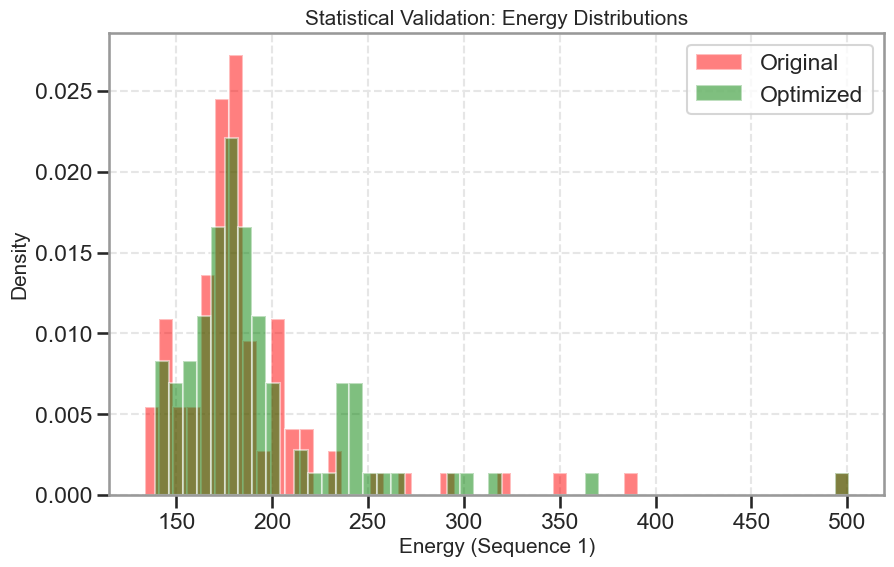

In [10]:
n_val_iter = 50000
print(f"Running Validation (N={n_val_iter})...")

# Run Original
out_slow = og_slow.overlapped_sequence_generator_int(
    DCA_params_1, DCA_params_2, bench_initial_seq, 
    T1=t1, T2=t2, numberofiterations=n_val_iter, quiet=True, whentosave=0.01
)
energies_slow = out_slow[2] # Energy 1 history

# Run Optimized
out_fast = og_opt.overlapped_sequence_generator_int(
    DCA_params_1, DCA_params_2, bench_initial_seq, 
    T1=t1, T2=t2, numberofiterations=n_val_iter, quiet=True, whentosave=0.01
)
energies_fast = out_fast[2] # Energy 1 history

# Plotting Histograms
plt.figure(figsize=(10, 6))
plt.hist(energies_slow, bins=50, alpha=0.5, label='Original', density=True, color='red')
plt.hist(energies_fast, bins=50, alpha=0.5, label='Optimized', density=True, color='green')
plt.xlabel('Energy (Sequence 1)')
plt.ylabel('Density')
plt.title('Statistical Validation: Energy Distributions')
plt.legend()
plt.show()

## 4. Throughput Summary

In [9]:
# Calculate throughput from the largest run in Scaling Analysis
max_iter = iteration_counts[-1]
time_slow_max = times_slow[-1]
time_fast_max = times_fast[-1]

tps_slow = max_iter / time_slow_max
tps_fast = max_iter / time_fast_max
speedup = tps_fast / tps_slow

print(f"--- Throughput Summary (N={max_iter}) ---")
print(f"Original:  {tps_slow:,.2f} iter/sec")
print(f"Optimized: {tps_fast:,.2f} iter/sec")
print(f"Speedup:   {speedup:.2f}x")

--- Throughput Summary (N=500000) ---
Original:  18,141.39 iter/sec
Optimized: 1,053,056.76 iter/sec
Speedup:   58.05x
